# [1] Scipy로 A/B 테스트 검증하기

In [54]:
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [56]:
# 예제 데이터: 두 그룹의 페이지 체류시간(초)
group_a = np.array([45, 52, 48, 55, 42, 50, 47, 53, 49, 51])  # 기존 디자인
group_b = np.array([58, 62, 55, 60, 57, 63, 59, 61, 56, 64])  # 새 디자인

In [57]:
len(group_a), len(group_b)

(10, 10)

In [58]:
# 우리가 가지고 있는 측정 변수(meric) 의 형태는?
# 1. 연속형
# 2. 범주형

In [59]:
type(group_a[0]) # => 연속형

numpy.int64

In [60]:
# 연속형 -> 평균 비교
# H0 : A그룹의 평균과 B그룹의 평균이 같다.
# (양측검정)H1 : A그룹의 평균과 B그룹의 평균은 다르다.
# (단측검정)H1 : A그룹의 평균보다 B그룹의 평균이 크다 (A<B)

print(f"group A의 평균 체류 시간 : {group_a.mean()} 초")
print(f"group B의 평균 체류 시간 : {group_b.mean()} 초")

group A의 평균 체류 시간 : 49.2 초
group B의 평균 체류 시간 : 59.5 초


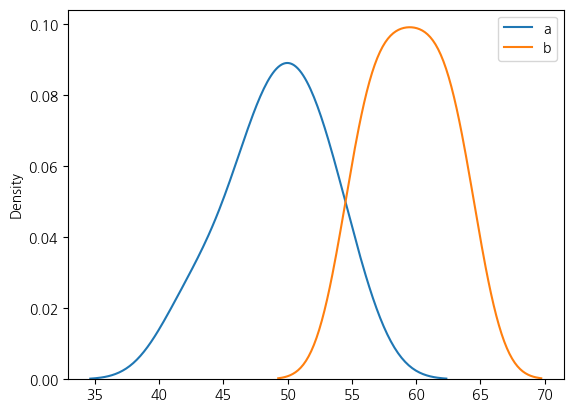

In [61]:
sns.kdeplot(group_a)
sns.kdeplot(group_b)
plt.legend(['a','b'])

In [62]:
# 독립 표본 t-검정 수행

t_stat, p_value = stats.ttest_ind(a=group_a, b=group_b)

print(f"검정통계량 : {t_stat}")
print(f"p-value : {p_value}")

검정통계량 : -6.6165354947459045
p-value : 3.2690903948414335e-06


In [63]:
if p_value < 0.05:
    print('== 귀무 가설 기각 == ')
    print('두 그룹 체류시간에 통계적으로 유의미한 차이가 있다.')
else:
    print('== 귀무 가설 기각 실패 ==')
    print('두 그룹 체류시간에 통계적으로 유의미한 차이가 없다.')

== 귀무 가설 기각 == 
두 그룹 체류시간에 통계적으로 유의미한 차이가 있다.


## [2] 실전! A/B 테스트 검증

| 🥬새벽마켓 — 상품 상세 페이지 리뉴얼 A/B 테스트
- 새벽마켓(식품 새벽배송 서비스) PM팀이 상품 상세 페이지를 리뉴얼했습니다.
- 변경 내용: 상품 상세 페이지에 리뷰 - 요약 + 레시피 추천 섹션 추가
- 실험 대상: 2주간 방문한 사용자 4,000명
- A 그룹 (2,000명): 기존 상세 페이지
- B 그룹 (2,000명): 리뉴얼 상세 페이지 (리뷰 요약 + 레시피)

In [64]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [65]:
path = '/content/drive/MyDrive/새싹2기/python_DA/data/'
df = pd.read_csv(path + 'ab_test_sample_data.csv')

In [66]:
df.head()

,user_id,group,stay_time,clicked
0,A_0,A,52.450712,0
1,A_1,A,42.926035,0
2,A_2,A,54.715328,0
3,A_3,A,67.845448,0
4,A_4,A,41.487699,0


In [67]:
df.shape

(4000, 4)

In [68]:
df['group'].value_counts()

,count
group,
A,2000
B,2000


### (1) 평균 체류시간

In [69]:
group_a = df.loc[df['group'] == 'A', 'stay_time']
group_b = df.loc[df['group'] == 'B', 'stay_time']

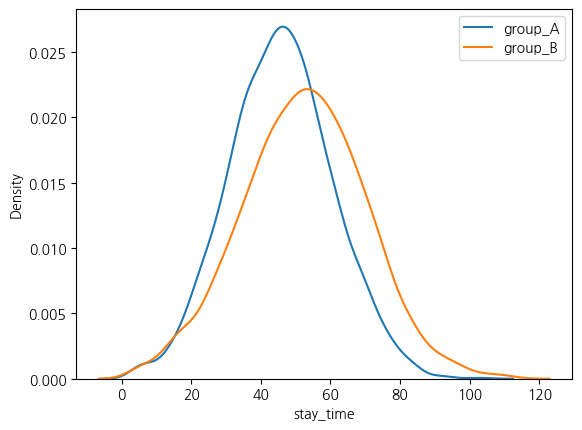

In [70]:
sns.kdeplot(group_a)
sns.kdeplot(group_b)
plt.legend(['group_A', 'group_B'])

In [71]:
_, p_value_stay = stats.ttest_ind(a=group_a, b=group_b)

In [72]:
p_value

np.float64(3.2690903948414335e-06)

In [73]:
_

np.float64(-12.873875909382898)

In [74]:
alpha = 0.05
if p_value < alpha:
  print('귀무가설 기각')
  print('A 그룹과 B그룹의 차이가 통계적으로 유의미하다')
else:
  print('귀무가설 기각 불가')

귀무가설 기각
A 그룹과 B그룹의 차이가 통계적으로 유의미하다


In [75]:
# 귀무가설(H0):  A 그룹의 평균 체류시간과 B그룹 체류시간의 평균이 같다.
# 대립가설(H1):  A 그룹의 평균 체류시간과 B그룹 체류시간의 평균이 같지 않다.

### (2) CTA 클릭율

In [76]:
df.head()

,user_id,group,stay_time,clicked
0,A_0,A,52.450712,0
1,A_1,A,42.926035,0
2,A_2,A,54.715328,0
3,A_3,A,67.845448,0
4,A_4,A,41.487699,0


In [77]:
df['clicked'].value_counts()

,count
clicked,
0,3489
1,511


In [78]:
df.groupby(['group','clicked'])['user_id'].count().unstack()

clicked,0,1
group,,
A,1781,219
B,1708,292


In [79]:
# 교차표 = 카이제곰 검정의 입력값
table = pd.crosstab(df['group'],df['clicked'])

In [80]:
df.groupby('group')['clicked'].mean()

,clicked
group,
A,0.1095
B,0.1460


In [81]:
219/2000

0.1095

In [82]:
_, p_value, _, _ = stats.chi2_contingency(table)

In [83]:
p_value

np.float64(0.0006487469503895386)

In [84]:
alpha = 0.05
if p_value < alpha:
  print('==귀무가설 기각==')
  print('A 그룹과 B 그룹의 전환율은 유의미한 차이가 있다.')
else:
  print('==귀무가설 기각 불가==')
  print('A 그룹과 B 그룹의 전환율은 유의미한 차이가 있다고 할 수 없다.')

==귀무가설 기각==
A 그룹과 B 그룹의 전환율은 유의미한 차이가 있다.


Text(0.5, 1.0, 'stay_time 실험 결과 (P-value: 3.428863308248705e-37)')

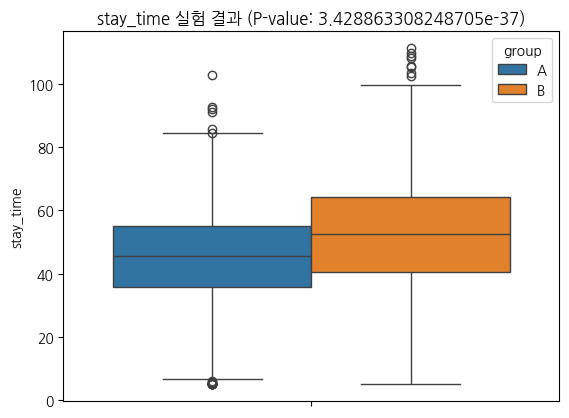

In [87]:
sns.boxplot(data=df, hue='group', y='stay_time')
plt.title(f'stay_time 실험 결과 (P-value: {p_value_stay})')

Text(0.5, 1.0, 'CTA 클릭율 (p-value: 3.428863308248705e-37)')

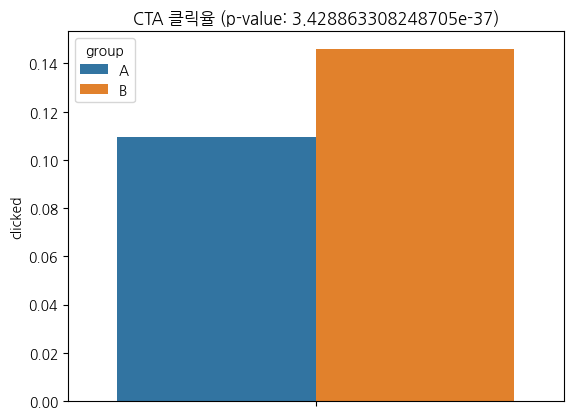

In [93]:
sns.barplot(data=df, hue='group', y='clicked', estimator='mean', errorbar=None)
plt.title(f'CTA 클릭율 (p-value: {p_value_stay})')